Since we got some difficulty deploying the model in TensorFlow format, we decided to try using PyTorch models instead. This notebook provides an end to end process of training PyTorch models, from downloading the data to save the trained model, load, and making predictions with it.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
!wget https://raw.githubusercontent.com/vishalrk1/pytorch/main/Pytorch_Helper.py
from Pytorch_Helper import LabelEncoder, Tokenizer, Trainer

--2023-06-11 02:57:00--  https://raw.githubusercontent.com/vishalrk1/pytorch/main/Pytorch_Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘Pytorch_Helper.py’

Pytorch_Helper.py   100%[===================>]  10.76K  --.-KB/s    in 0s      

2023-06-11 02:57:01 (86.7 MB/s) - ‘Pytorch_Helper.py’ saved [11016/11016]



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64

max_length = 128

cuda


## Get the data ready
To get our data in a clean Dataframe format, we're going to set some functions to do that:
- `get_lines()` - To read the lines of documents.
- `preprocess_text_with_line_numbers()` - To preprocess the data into list of dictionaries, so we can turn it into a dataframe.

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictonaries of abstract line data.

  Takes in filename, reads some content and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename) # get all of the line
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line on the target file
  for line in input_lines:
    # 1. Start
    if line.startswith("###"): # check to see if this an ID line
      abstract_id = line # put the id to variable
      abstract_lines = "" # reset the abstract string if the line is an ID line

    # 3.End (split input_lines into individual abstract and store on dict)
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines and turn `abstract_lines` into list (see above instruction)

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split): # KEYNOTE: split into individual line on each abstract

        target_text_split = abstract_line.split('\t') # split target label from text

        # Create dictionary and put it into list
        line_data = {} # create an empty dictionary for each line
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from zero)
        abstract_samples.append(line_data) # add line data to abstract samples list

    # 2.Add line to abstract_lines
    else: # if the above condition doesn't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# 1. Download the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
# Start our experiments using the 20K dataset with number replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

# 2. Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

# 3. Turn it into dataframes so we can visualize it later
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.64 MiB/s, done.
Updating files: 100% (13/13), done.


<Axes: >

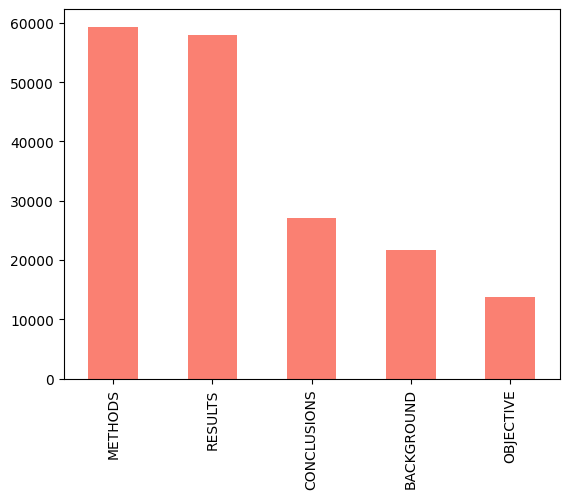

In [ ]:
# Distributions of labels in training data
train_df['target'].value_counts().plot(kind="bar", color="salmon")

<Axes: ylabel='Frequency'>

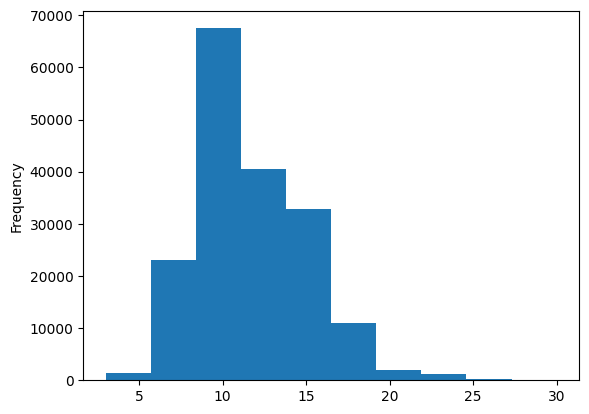

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist() # number of sentences per abstract

## Preprocessing Data

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in paranthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text


# Apply to dataframe
preprocessed_df = train_df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess)
print (f"{train_df.text.values[0]}\n\n{preprocessed_df.text.values[0]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we']
to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .

investigate efficacy weeks daily low dose oral prednisolone improving pain mobility systemic low grade inflammation short term whether effect would sustained weeks older adults moderate severe knee osteoarthritis


In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Spliting Data into train, test and validation dataset

In [ ]:
import collections
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.7
VAL_SIZE = 0.20
TEST_SIZE = 0.10

def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Data
X = preprocessed_df["text"].values
y = preprocessed_df["target"].values

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (126027,), y_train: (126027,)
X_val: (27006,), y_val: (27006,)
X_test: (27007,), y_test: (27007,)
Sample point: original nonoperatively treated group twenty three patients data obtained eighteen two patients died three could located → RESULTS


# Label Encoding

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
print(NUM_CLASSES)

label_encoder.class_to_index

5


{'BACKGROUND': 0, 'CONCLUSIONS': 1, 'METHODS': 2, 'OBJECTIVE': 3, 'RESULTS': 4}

In [ ]:
class_names = label_encoder.class_to_index.keys()
class_names

dict_keys(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])

In [ ]:
# Converting all targets into numbers
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)

In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)} # inverse of the number of times that labels appear
print (f"counts: {counts}\nweights: {class_weights}")

counts: [15209 19017 41547  9687 40567]
weights: {0: 6.575054244197515e-05, 1: 5.258452963138245e-05, 2: 2.4069126531398175e-05, 3: 0.00010323113451016826, 4: 2.4650578056055415e-05}


# Tokenizer

In [ ]:
tokenizer = Tokenizer(char_level=False, num_tokens=60000)

In [ ]:
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print(VOCAB_SIZE)

38740


In [ ]:
from more_itertools import take

# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}")

[('<PAD>', 0), ('<UNK>', 1), ('patients', 2), ('group', 3), ('treatment', 4)]
least freq token's freq: 1


In [ ]:
# Converting texts to sequence of numbers
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[0]

array([ 2104, 11701,    89,     3,   519,    73,     2,    60,   450,
        3350,    16,     2,  1308,    73,   228,  3721])

## Padding Function

In [ ]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

# Trainer

In [ ]:
from tqdm.notebook import tqdm # loop progress bar

class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None, save_path=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_path = save_path

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0
        acc = 0.0

        # Iterate over train batches
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)
            acc += self.calculate_accuracy(z, targets)

        return loss, acc

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        acc = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)
                acc += self.calculate_accuracy(z, y_true)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, acc, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_trues, y_probs = [], []
        acc = 0.0

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

                # Forward pass w/ inputs
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                acc += self.calculate_accuracy(z, targets)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true)

        acc = acc / len(dataloader)
        return acc, np.vstack(y_trues), np.vstack(y_probs)

    def calculate_accuracy(self, output, labels):
      output_class = torch.softmax(output, dim=1).argmax(dim=1)
      train_acc = (output_class == labels).sum().item()/len(output)
      return train_acc

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            print(f"<----- Epoch: {epoch+1} ----->")
            # Steps
            train_loss, train_acc = self.train_step(dataloader=train_dataloader)
            val_loss, val_acc, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                if self.save_path is not None:
                  print('Saving Model!!')
                  torch.save(self.model.state_dict(), self.save_path)
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            train_acc = train_acc / len(train_dataloader)
            val_acc = val_acc / len(val_dataloader)

            # Logging
            print(
                f"train Loss: {train_loss:.5f},\t"
                f"train Accuracy: {train_acc:.2f},\n"
                f"val Loss: {val_loss:.5f}, \t"
                f"val Accuracy: {val_acc:.2f}, \n"
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, \t"
                f"_patience: {_patience}"
                "\n"
            )
        return best_model

# Positional Encoding

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


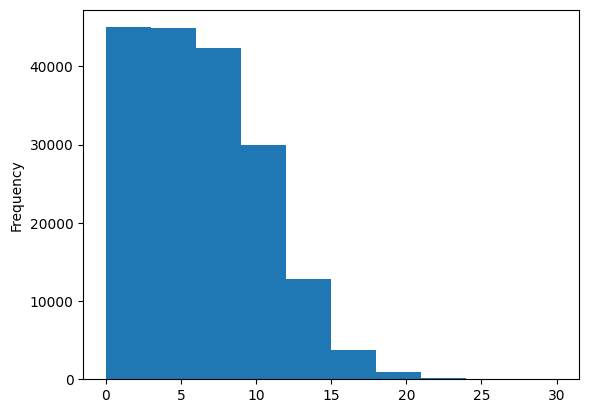

In [ ]:
train_df['line_number'].plot.hist();

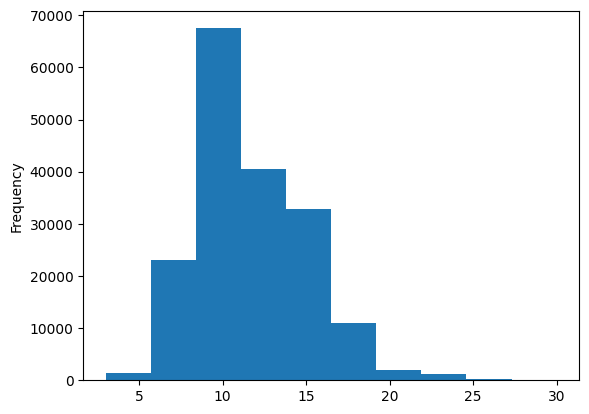

In [ ]:
train_df['total_lines'].plot.hist();

# Skimlit Dataset

In [ ]:
class SkimlitDataset(Dataset):
  def __init__(self, text_seq, target, line_num_one_hot, total_line_one_hot):
    self.text_seq = text_seq
    self.target = target
    self.line_num_one_hot = line_num_one_hot
    self.total_line_one_hot = total_line_one_hot

  def __len__(self):
    return len(self.target)

  def __str__(self):
    return f"<Dataset(N={len(self)})>"

  def __getitem__(self, index):
    X = self.text_seq[index]
    y = self.target[index]
    line_num = self.line_num_one_hot[index]
    total_line = self.total_line_one_hot[index]
    return [X, len(X), line_num, total_line, y]

  def collate_fn(self, batch):
    """Processing on a batch"""
    # Getting Input
    batch = np.array(batch)
    text_seq = batch[:, 0]
    seq_lens = batch[:, 1]
    line_nums = batch[:, 2]
    total_lines = batch[:, 3]
    target = batch[:, 4]

    # padding inputs
    pad_text_seq = pad_sequences(sequences=text_seq) # max_seq_len=max_length

    # converting line nums into one-hot encoding
    line_nums = tf.one_hot(line_nums, depth=20)

     # converting total lines into one-hot encoding
    total_lines = tf.one_hot(total_lines, depth=24)

    # converting inputs to tensors
    pad_text_seq = torch.LongTensor(pad_text_seq.astype(np.int32))
    seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
    line_nums = torch.tensor(line_nums.numpy())
    total_lines = torch.tensor(total_lines.numpy())
    target = torch.LongTensor(target.astype(np.int32))

    return pad_text_seq, seq_lens, line_nums, total_lines,  target

  def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
    dataloader = DataLoader(dataset=self, batch_size=batch_size, collate_fn=self.collate_fn, shuffle=shuffle, drop_last=drop_last, pin_memory=True)
    return dataloader


In [ ]:
# Creating Datasets
train_dataset = SkimlitDataset(text_seq=X_train, target=y_train, line_num_one_hot=train_df['line_number'], total_line_one_hot=train_df['total_lines'])
val_dataset = SkimlitDataset(text_seq=X_val, target=y_val, line_num_one_hot=val_df['line_number'], total_line_one_hot=val_df['total_lines'])
test_dataset = SkimlitDataset(text_seq=X_test, target=y_test, line_num_one_hot=test_df['line_number'], total_line_one_hot=test_df['total_lines'])

In [ ]:
train_dataset[0]

[array([ 2104, 11701,    89,     3,   519,    73,     2,    60,   450,
         3350,    16,     2,  1308,    73,   228,  3721]),
 16,
 0,
 11,
 4]

In [ ]:
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1970, 422, 422)

In [ ]:
batch_text_seq, batch_seq_len, batch_line_num, batch_total_line, batch_target = next(iter(train_dataloader))

batch_line_num.shape, batch_total_line.shape, batch_line_num

<ipython-input-26-8b1a201dfb17>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)


(torch.Size([64, 20]),
 torch.Size([64, 24]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

# Preparing Pretrained Embeddings

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2023-06-11 02:57:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-11 02:57:44 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Downloading glove embeddings files
!wget http://nlp.stanford.edu/data/glove.6B.zip
unzip_data('/content/glove.6B.zip')

def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings

def make_embeddings_matrix(embeddings, word_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

--2023-06-11 02:57:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-11 02:57:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-11 02:57:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 128

# Create embeddings
embeddings_file = '/content/glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)

embedding_matrix = make_embeddings_matrix(
    embeddings=glove_embeddings, word_index=tokenizer.token_to_index,
    embedding_dim=EMBEDDING_DIM)

print (f"<Embeddings(words={embedding_matrix.shape[0]}, dim={embedding_matrix.shape[1]})>")

<Embeddings(words=38740, dim=300)>


# Skimlit Model

In [ ]:
def gather_last_relevant_hidden(hiddens, seq_lens):
    """Extract and collect the last relevant
    hidden state based on the sequence length."""
    seq_lens = seq_lens.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(seq_lens):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

In [ ]:
class SkimlitModel(nn.Module):
  def __init__(self, embedding_dim, vocab_size, hidden_dim, n_layers, linear_output, num_classes, pretrained_embeddings=None, padding_idx=0):
    super(SkimlitModel, self).__init__()

    # Initalizing embeddings
    if pretrained_embeddings is None:
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    else:
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, _weight=pretrained_embeddings, padding_idx=padding_idx)

    # LSTM layers
    self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)

    # FC layers
    self.fc_text = nn.Linear(2*hidden_dim, linear_output)

    self.fc_line_num = nn.Linear(20, 64)
    self.fc_total_line = nn.Linear(24, 64)

    self.fc_final = nn.Linear((64+64+linear_output), num_classes)
    self.dropout = nn.Dropout(0.3)

  def forward(self, inputs):
    x_in, seq_lens, line_nums, total_lines = inputs
    x_in = self.embeddings(x_in)

    # RNN outputs
    out, b_n = self.lstm1(x_in)
    x_1 = gather_last_relevant_hidden(hiddens=out, seq_lens=seq_lens)

    # FC layers output
    x_1 = F.relu(self.fc_text(x_1))
    x_2 = F.relu(self.fc_line_num(line_nums))
    x_3 = F.relu(self.fc_total_line(total_lines))

    x = torch.cat((x_1, x_2, x_3), dim=1)
    x = self.dropout(x)
    x = self.fc_final(x)
    return x

In [ ]:
model = SkimlitModel(embedding_dim=EMBEDDING_DIM,
                     vocab_size=VOCAB_SIZE,
                     hidden_dim=HIDDEN_DIM,
                     n_layers=3,
                     linear_output=128,
                     num_classes=NUM_CLASSES,
                     pretrained_embeddings=embedding_matrix)
model = model.to(device)

model

SkimlitModel(
  (embeddings): Embedding(38740, 300, padding_idx=0)
  (lstm1): LSTM(300, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc_text): Linear(in_features=256, out_features=128, bias=True)
  (fc_line_num): Linear(in_features=20, out_features=64, bias=True)
  (fc_total_line): Linear(in_features=24, out_features=64, bias=True)
  (fc_final): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
save_path = "/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/"

## Training

In [ ]:
trainer = Trainer(model=model,
                  device=device,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  save_path=save_path + "skimlit-pytorch-checkpoint.pt")

In [ ]:
best_model = trainer.train(num_epochs=20,
                           patience=5,
                           train_dataloader=train_dataloader,
                           val_dataloader=val_dataloader)

<----- Epoch: 1 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

<ipython-input-26-8b1a201dfb17>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)


  0%|          | 0/422 [00:00<?, ?it/s]

<ipython-input-22-87e0be3cd142>:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Saving Model!!
train Loss: 0.78228,	train Accuracy: 0.74,
val Loss: 0.75954, 	val Accuracy: 0.75, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 2 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train Loss: 0.69984,	train Accuracy: 0.77,
val Loss: 0.72579, 	val Accuracy: 0.76, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 3 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train Loss: 0.64424,	train Accuracy: 0.79,
val Loss: 0.71886, 	val Accuracy: 0.76, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 4 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train Loss: 0.59906,	train Accuracy: 0.81,
val Loss: 0.73163, 	val Accuracy: 0.76, 
lr: 1.00E-04, 	_patience: 4

<----- Epoch: 5 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train Loss: 0.55938,	train Accuracy: 0.82,
val Loss: 0.75554, 	val Accuracy: 0.75, 
lr: 1.00E-04, 	_patience: 3

<----- Epoch: 6 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train Loss: 0.52361,	train Accuracy: 0.83,
val Loss: 0.78355, 	val Accuracy: 0.75, 
lr: 1.00E-04, 	_patience: 2

<----- Epoch: 7 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train Loss: 0.48952,	train Accuracy: 0.85,
val Loss: 0.81142, 	val Accuracy: 0.75, 
lr: 1.00E-05, 	_patience: 1

<----- Epoch: 8 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Stopping early!


## Evaluation of Model

In [ ]:
import json
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [ ]:
# Get predictions
test_loss, test_acc, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)
print(f"Test Accuracy: {test_acc/len(test_dataloader)}")

# Determine performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

  0%|          | 0/422 [00:00<?, ?it/s]

<ipython-input-26-8b1a201dfb17>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-22-87e0be3cd142>:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Test Accuracy: 0.7659141559467388
{
  "precision": 0.770850549588432,
  "recall": 0.765912541193024,
  "f1": 0.767976117740649,
  "num_samples": 27007.0
}


## Saving files

In [ ]:
# Save artifacts
from pathlib import Path
import json

dir = Path(save_path + "utils")
dir.mkdir(parents=True, exist_ok=True)

label_encoder.save(fp=Path(dir, "label_encoder.json"))
tokenizer.save(fp=Path(dir, "tokenizer.json"))
torch.save(best_model.state_dict(), Path(dir, "skimlit-model-final-1.pt"))

with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

# Load the model and make inferences

In [ ]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [ ]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
tokenizer = Tokenizer.load(fp=Path(dir, "tokenizer.json"))

model = SkimlitModel(embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, n_layers=3, linear_output=128, num_classes=NUM_CLASSES, pretrained_embeddings=embedding_matrix)

model.load_state_dict(torch.load(Path(dir, "skimlit-model-final-1.pt"), map_location=device))
model.to(device)

SkimlitModel(
  (embeddings): Embedding(38740, 300, padding_idx=0)
  (lstm1): LSTM(300, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc_text): Linear(in_features=256, out_features=128, bias=True)
  (fc_line_num): Linear(in_features=20, out_features=64, bias=True)
  (fc_total_line): Linear(in_features=24, out_features=64, bias=True)
  (fc_final): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
trainer = Trainer(model=model, device=device, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, save_path=save_path + "skimlit-pytorch-3.pt")

# Get predictions
acc, y_true, y_prob = trainer.predict_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)
print(f"Test Accuracy: {acc}")

# Determine performance
# performance = get_metrics(y_true=y_true, y_pred=y_pred, classes=label_encoder.classes)
# print (json.dumps(performance["overall"], indent=2))

  0%|          | 0/422 [00:00<?, ?it/s]

<ipython-input-26-8b1a201dfb17>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-22-87e0be3cd142>:87: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Test Accuracy: 0.7659141559467388
